In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyarrow

In [0]:
%load feature_calculators

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

import feature_calculators as fc

from numba import jit
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Here, I work on the dataset.

In [0]:
labels_df = pd.read_csv(f'{PATH_LABELS}/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

In [8]:
train_df = pd.read_feather(f'{PATH_FEATURES}/train')

train_df.drop('unique_counts', axis=1, inplace=True)

train_df = pd.merge(train_df, labels_df,
                    left_on='bookingID', right_on='bookingID',
                    how='inner')

train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891,0
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516,0
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825,0
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397,0
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941,0


In [9]:
len(train_df)

16116704

## EDA

In [10]:
ids = train_df['bookingID'].unique().tolist()

len(ids)

19982

In [0]:
ids[:10]

features = [c for c in train_df.columns if c not in ['label', 'bookingID']]

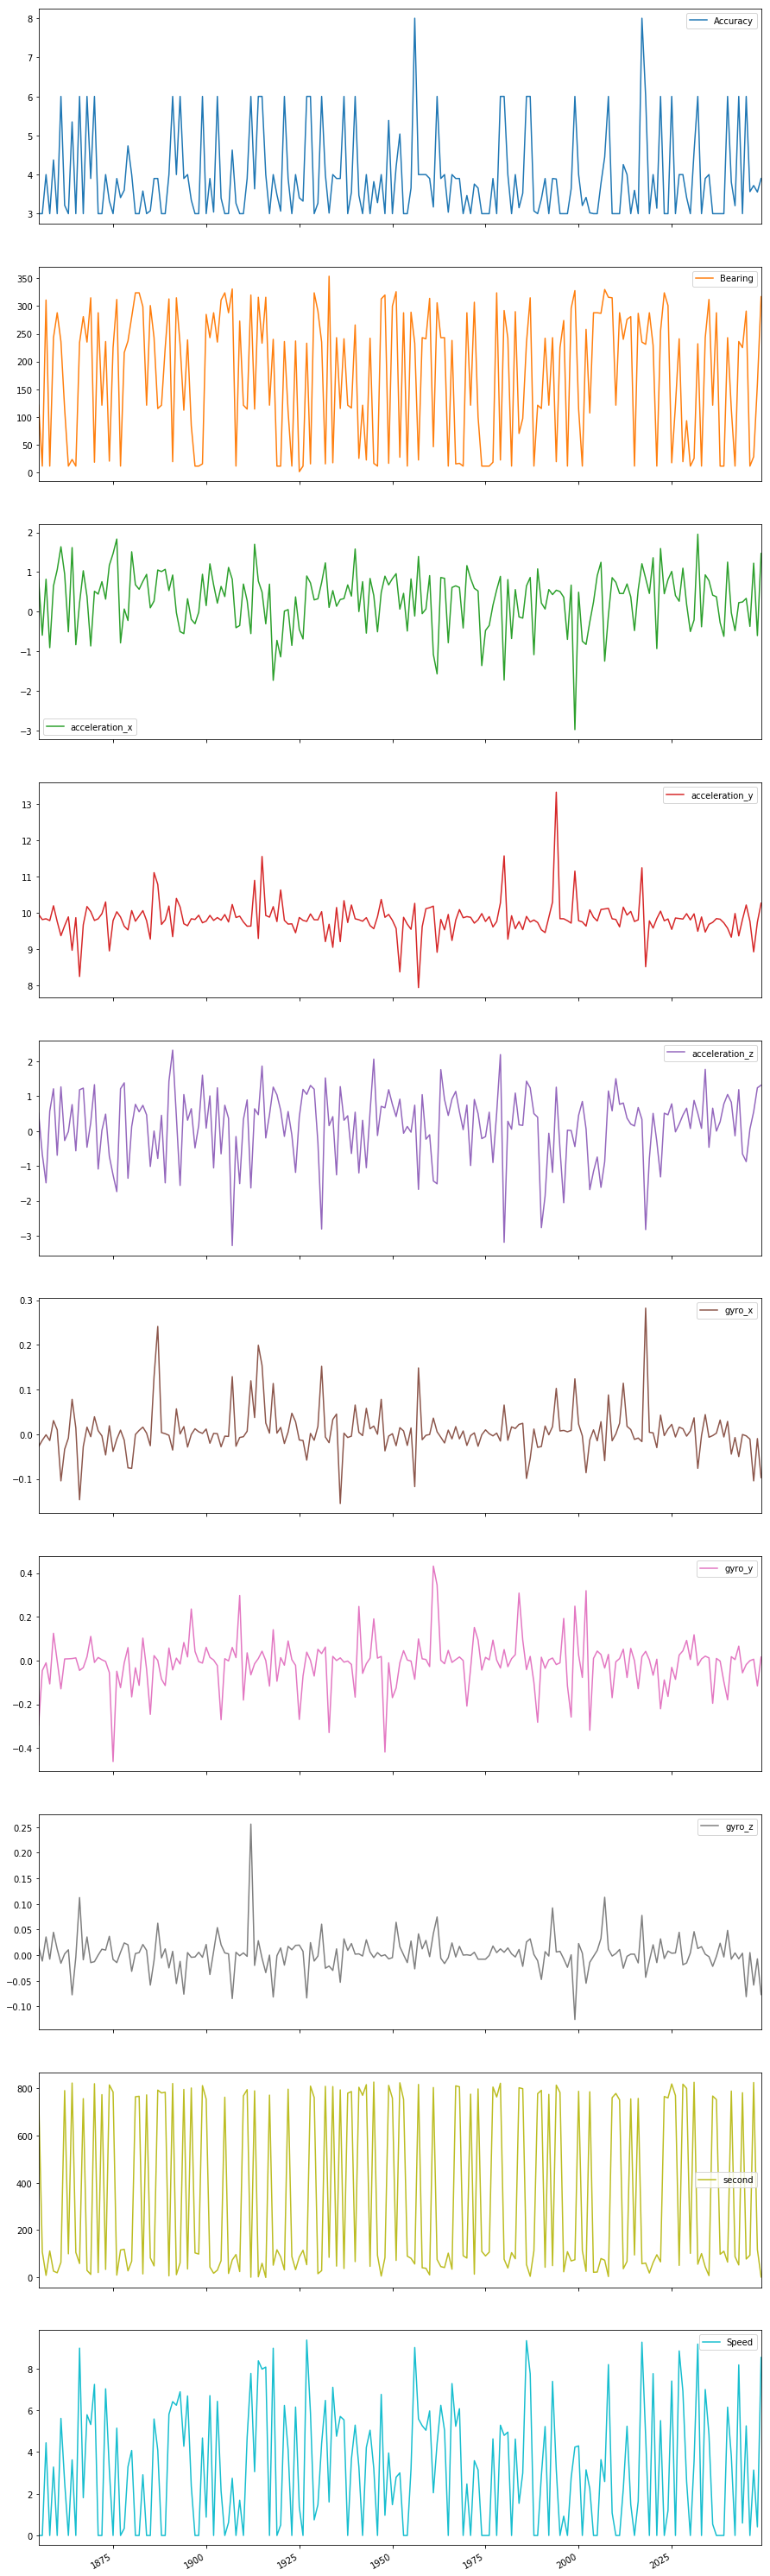

In [12]:
train_df[train_df['bookingID'] == 2][features].plot(subplots=True, sharex=True, figsize=(15,60))
plt.show()

In [0]:
# # explore an ID
# example = train_df[(train_df['bookingID'] == 0) |
#                    (train_df['bookingID'] == 1709396983975)]

# ids = example['bookingID'].unique()

# print(ids)

# # highest accuracy
# np.sort(example['Accuracy'].values)[::-1]

# example[example['Accuracy'] > 20]

In [0]:
# example.describe()

## Feature engineering
Some ideas are taken from this [discussion](https://www.kaggle.com/c/axa-driver-telematics-analysis/discussion/12848#latest-66913) and [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

In [0]:
def total_a(df):
    # acceleration combining all directions
    total_a = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_a'] = np.sqrt(total_a)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
def roll(df):
    # roll  
    yz = df[['acceleration_y', 'acceleration_z']].values
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll'] = np.arctan2(y, z)
      
def pitch(df):
    # pitch
    xyz = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))
    
def horsepower(df):
    df['horsepower'] = df['total_a'] * df['Speed']
    
def aggressive_turn(df):
    pass
  
def jerk(df):
    pass
  
def a_threshold(df):
    # and difference > threshold
    pass  
  
def fe(df):
    total_a(df)
    total_gyro(df)
    roll(df)
    pitch(df)
    horsepower(df)

In [16]:
%%time
fe(train_df)

CPU times: user 4.54 s, sys: 1.59 s, total: 6.13 s
Wall time: 6.11 s


In [17]:
exclude = ['label', 'bookingID', 'unique_counts']

features = [c for c in train_df.columns if c not in exclude]

len(features)

# features

15

In [35]:
train_df['gyro_x'].mean()

-0.0017082574241395604

In [0]:
subfeatures = ('acceleration_x', 'acceleration_y', 'acceleration_z',
               'gyro_x', 'gyro_y', 'gyro_z')

In [0]:
def feature_gen(subset)
    sub_df = pd.DataFrame()
    for f in subfeatures:
        readings = subset[f].values
        
        sub_df['abs_energy_' + f] = fc.abs_energy(readings)
        sub_df['abs_energy_' + f] = fc.count_above_mean(readings)
        
        
        fc.count_below_mean,
        fc.absolute_sum_of_changes,
        fc.first_location_of_maximum,
        fc.first_location_of_minimum,
        fc.kurtosis,
        fc.last_location_of_maximum,
        fc.last_location_of_minimum,
        fc.length,
        fc.longest_strike_above_mean,
        fc.longest_strike_below_mean,
        fc.mean_abs_change,
        fc.mean_change,
        fc.median,
        fc.minimum,
        fc.maximum,
        fc.sample_entropy,
        fc.skewness,
        fc.kurtosis,
        fc.standard_deviation   

    

In [0]:
def build_features(booking_id):
    sample = train_df[train_df['bookingID'] == booking_id]
    delta = feature_gen(sample['acoustic_data'].values)
    delta['seg_id'] = seg_id
    return delta

In [0]:
from joblib import Parallel, delayed
import multiprocessing

def tmpFunc(df):
    df['c'] = df.a + df.b
    return df

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

df = pd.DataFrame({'a': [6, 2, 2], 'b': [4, 5, 6]},index= ['g1', 'g1', 'g2'])
print 'parallel version: '
print applyParallel(df.groupby(df.index), tmpFunc)

In [0]:
%%time

funcs = [
    fc.abs_energy,
    fc.count_above_mean,
    fc.count_below_mean,
    fc.absolute_sum_of_changes,
    fc.first_location_of_maximum,
    fc.first_location_of_minimum,
    fc.kurtosis,
    fc.last_location_of_maximum,
    fc.last_location_of_minimum,
    fc.length,
    fc.longest_strike_above_mean,
    fc.longest_strike_below_mean,
    fc.mean_abs_change,
    fc.mean_change,
    fc.median,
    fc.minimum,
    fc.maximum,
    fc.sample_entropy,
    fc.skewness,
    fc.kurtosis,
    fc.standard_deviation   
]

# fc.time_reversal_asymmetry_statistic(x[f],
#                                      lag=3)

# fc.number_crossing_m(x[f],
#                      m=df[f].mean())

# fc.number_peaks(x[f],
#                 n=5)

# fc.binned_entropy(x[f],
#                  max_bins=10)

# fc.change_quantiles(x[f], 
#                    0.2, 0.8, 
#                    isabs=True, std)

# new1 = train_df.groupby('bookingID').apply(lambda x: fc.autocorrelation(x[f],
#                                                                        lag=3))

for f in subfeatures:
    new = train_df.groupby('bookingID')[f].agg(funcs)
    break
    
new    

In [25]:
new.reset_index().head()

,bookingID,abs_energy,count_above_mean
0,0,1371.728240,494.0
1,1,705.624022,406.0
2,2,129.403828,114.0
3,4,449.653780,520.0
4,6,1010.471422,519.0


## Accuracy
Extract the `TOP_N` highest accuracy features.

In [0]:
@jit(nopython=True)
def accuracy_features(accuracy, feature, TOP_N=1):
    idxs = np.argsort(accuracy)[::-1][:TOP_N]
    return feature[idxs]

In [0]:
# %%time
# TOP_N_SPEED_2 = np.empty((len(ids), TOP_N))
# # TOP_N_HP = np.empty((len(ids), TOP_N))

# for i in tqdm(range(len(ids))):
#     accuracy = train_df[train_df['bookingID'] == ids[i]]['Accuracy'].values
#     features = train_df[train_df['bookingID'] == ids[i]]['Speed'].values

#     TOP_N_SPEED_2[i] = accuracy_features(accuracy, features, 3)    

In [0]:
def top_accuracy_f(bookingID, df, f, N=1):
  
    subset = df[df['bookingID'] == bookingID]   
    
    # get indices with top N highest accuracy
    idxs = np.argsort(subset['Accuracy'].values)[::-1][:N]    
    
    return subset.iloc[idxs][f].values.T

In [0]:
gc.collect()

891

In [0]:
# %%time
# TOP_N = 3

# TOP_N_SPEED = np.empty((len(ids), TOP_N))
# TOP_N_HP = np.empty((len(ids), TOP_N))

# for i in range(len(ids)):
#     TOP_N_SPEED[i] = top_accuracy_f(ids[i], train_df, 'Speed', TOP_N)
#     TOP_N_HP[i] = top_accuracy_f(ids[i], train_df, 'horsepower', TOP_N)

## Normalization

In [0]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from tqdm import tqdm

# def normalize_by_ids(df):
#     drivers = df['bookingID'].unique()
#     for driver in tqdm(drivers):
#         ids = df[df['bookingID'] == driver].index
#         scaler = MinMaxScaler()
#         df.loc[ids, features] = scaler.fit_transform(df.loc[ids, features])
        
# normalize_by_ids(sub_df)

In [0]:
# =======
# differentiation features
# =======
def fo(x):
    return np.diff(x)

def so(x):
    return np.diff(fo(x))

def fo_mean(x):
    # first order diff mean
    return np.mean(fo(x))

def so_mean(x):
    # second order diff mean
    return np.mean(so(x))         

def fo_min(x):
    # first order diff min
    return np.min(fo(x))

def so_min(x):
    # second order diff min
    return np.min(so(x))   

def fo_max(x):
    # first order diff max
    return np.max(fo(x))

def so_max(x):
    # second order diff max
    return np.max(so(x))  

def sign_change(x):
    return sum(np.diff(np.sign(x)) != 0)

In [0]:
def agg_features(df, new_df):
  
    # statistical features
    func = ('min', 'max', 'mean', 'std')
    
    exclude = ('label', 'bookingID', 'unique_counts')

    # performed on all features
    features = (c for c in df.columns if c not in exclude)   
    
    for f in features:
        new = df.groupby('bookingID')[f].agg(func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
    
    print('Done statistical features...')
    print('Now to differentiation features...')
    
    diff_func = (fo_mean, fo_min, fo_max,
                 so_mean, so_min, so_max,
                 sign_change)
    
    subfeatures = ('acceleration_x', 'acceleration_y', 'acceleration_z',
                   'gyro_x', 'gyro_y', 'gyro_z')
    
    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(diff_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
                
    return new_df        

In [0]:
new_df = pd.DataFrame()

new_df['bookingID'] = ids

len(new_df)

19982

In [0]:
%%time
sample_new = agg_features(train_df, new_df)

Done statistical features...
Now to differentiation features...
CPU times: user 5min 26s, sys: 1.43 s, total: 5min 27s
Wall time: 5min 27s


In [0]:
sample_new.head()

,bookingID,Accuracy_min,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_min,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_min,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_min,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_min,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_min,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_min,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_min,gyro_z_max,gyro_z_mean,gyro_z_std,second_min,second_max,second_mean,second_std,Speed_min,Speed_max,Speed_mean,...,acceleration_x_fo_max,acceleration_x_so_mean,acceleration_x_so_min,acceleration_x_so_max,acceleration_x_sign_change,acceleration_y_fo_mean,acceleration_y_fo_min,acceleration_y_fo_max,acceleration_y_so_mean,acceleration_y_so_min,acceleration_y_so_max,acceleration_y_sign_change,acceleration_z_fo_mean,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change
0,0,4.0,48.000,10.165339,3.855898,0.037464,359.979767,176.526099,129.231351,-4.692294,4.782614,-0.711264,0.928022,-12.764703,-6.119916,-9.613822,0.639934,-6.251807,2.318857,-1.619658,1.141266,-0.392537,0.438371,0.003328,0.065954,-0.609930,0.469724,-0.006118,0.100225,-0.731892,0.372807,-0.004188,0.063685,0.0,1589.0,903.526892,533.745097,-1.0,22.946083,8.994822,...,4.873383,-0.001960,-10.184308,8.453427,278.0,0.000324,-3.953137,3.903342,0.000934,-7.856479,5.524164,0.0,0.001660,-4.960413,6.332556,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0
1,1,3.0,7.709,3.718763,0.597933,0.000000,337.000000,124.198590,89.861236,-5.352994,3.813341,-0.525406,0.744157,6.623425,12.536156,9.532086,0.533915,-5.355455,1.481293,-2.198999,0.854271,-0.125367,0.126536,-0.002467,0.027740,-0.678183,0.470837,-0.007540,0.091699,-0.121265,0.235131,0.000405,0.033838,0.0,1034.0,581.175088,289.339367,-1.0,21.882141,7.881588,...,5.112138,0.001334,-8.524900,8.847361,180.0,-0.000785,-3.323172,3.170564,0.000634,-6.294559,6.425989,0.0,0.001054,-5.032708,5.158748,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0
2,2,3.0,8.000,3.930626,1.117354,1.000000,354.000000,173.794872,119.316520,-2.971295,1.956122,0.306786,0.756589,7.941810,13.333716,9.843183,0.505693,-3.282551,2.312870,0.139347,1.020021,-0.155218,0.282162,0.006458,0.053903,-0.462000,0.431695,-0.012861,0.117321,-0.125907,0.255884,0.002597,0.036215,0.0,825.0,339.441026,356.319445,0.0,9.360483,3.157213,...,3.464516,0.018050,-5.013611,7.108602,80.0,0.001592,-3.490852,3.031151,0.003449,-6.522003,4.005621,0.0,0.004134,-5.375147,4.326454,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0
3,4,10.0,10.000,10.000000,0.000000,2.271227,353.855377,151.807013,71.273774,-2.866458,2.019635,-0.365117,0.527220,-18.847833,-7.064984,-9.406439,0.598023,-9.374869,0.296381,-2.613639,0.779529,-0.420507,0.438732,-0.022884,0.042342,-0.506531,0.652628,0.023232,0.112567,-0.348189,0.505220,-0.000376,0.065927,0.0,1094.0,547.495430,315.962793,0.0,19.780001,6.150996,...,3.158801,0.001724,-5.133127,5.254550,299.0,0.000358,-9.794467,9.601715,-0.000093,-10.051071,19.396182,0.0,-0.001748,-8.202805,6.575403,0.001314,-10.440613,14.778207,4.0,0.0000

In [0]:
len(new)

19982

In [0]:
vc = train_df.groupby('bookingID').head(1)['unique_counts'].values

sample_new['vc'] = vc

sample_new.head()

,bookingID,Accuracy_min,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_min,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_min,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_min,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_min,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_min,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_min,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_min,gyro_z_max,gyro_z_mean,gyro_z_std,second_min,second_max,second_mean,second_std,Speed_min,Speed_max,Speed_mean,...,acceleration_x_so_mean,acceleration_x_so_min,acceleration_x_so_max,acceleration_x_sign_change,acceleration_y_fo_mean,acceleration_y_fo_min,acceleration_y_fo_max,acceleration_y_so_mean,acceleration_y_so_min,acceleration_y_so_max,acceleration_y_sign_change,acceleration_z_fo_mean,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,vc
0,0,4.0,48.000,10.165339,3.855898,0.037464,359.979767,176.526099,129.231351,-4.692294,4.782614,-0.711264,0.928022,-12.764703,-6.119916,-9.613822,0.639934,-6.251807,2.318857,-1.619658,1.141266,-0.392537,0.438371,0.003328,0.065954,-0.609930,0.469724,-0.006118,0.100225,-0.731892,0.372807,-0.004188,0.063685,0.0,1589.0,903.526892,533.745097,-1.0,22.946083,8.994822,...,-0.001960,-10.184308,8.453427,278.0,0.000324,-3.953137,3.903342,0.000934,-7.856479,5.524164,0.0,0.001660,-4.960413,6.332556,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,1004
1,1,3.0,7.709,3.718763,0.597933,0.000000,337.000000,124.198590,89.861236,-5.352994,3.813341,-0.525406,0.744157,6.623425,12.536156,9.532086,0.533915,-5.355455,1.481293,-2.198999,0.854271,-0.125367,0.126536,-0.002467,0.027740,-0.678183,0.470837,-0.007540,0.091699,-0.121265,0.235131,0.000405,0.033838,0.0,1034.0,581.175088,289.339367,-1.0,21.882141,7.881588,...,0.001334,-8.524900,8.847361,180.0,-0.000785,-3.323172,3.170564,0.000634,-6.294559,6.425989,0.0,0.001054,-5.032708,5.158748,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,851
2,2,3.0,8.000,3.930626,1.117354,1.000000,354.000000,173.794872,119.316520,-2.971295,1.956122,0.306786,0.756589,7.941810,13.333716,9.843183,0.505693,-3.282551,2.312870,0.139347,1.020021,-0.155218,0.282162,0.006458,0.053903,-0.462000,0.431695,-0.012861,0.117321,-0.125907,0.255884,0.002597,0.036215,0.0,825.0,339.441026,356.319445,0.0,9.360483,3.157213,...,0.018050,-5.013611,7.108602,80.0,0.001592,-3.490852,3.031151,0.003449,-6.522003,4.005621,0.0,0.004134,-5.375147,4.326454,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,195
3,4,10.0,10.000,10.000000,0.000000,2.271227,353.855377,151.807013,71.273774,-2.866458,2.019635,-0.365117,0.527220,-18.847833,-7.064984,-9.406439,0.598023,-9.374869,0.296381,-2.613639,0.779529,-0.420507,0.438732,-0.022884,0.042342,-0.506531,0.652628,0.023232,0.112567,-0.348189,0.505220,-0.000376,0.065927,0.0,1094.0,547.495430,315.962793,0.0,19.780001,6.150996,...,0.001724,-5.133127,5.254550,299.0,0.000358,-9.794467,9.601715,-0.000093,-10.051071,19.396182,0.0,-0.001748,-8.202805,6.575403,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,

In [0]:
def add_features(df, arr, f):
    for i in range(TOP_N):
        var = f + '_' + str(i+1)
        df[var] = arr[:, i]

# add the TOP_N accuracy features to the merged df
add_features(new, TOP_N_SPEED, 'Speed')
add_features(new, TOP_N_HP, 'horsepower')

In [0]:
# #     var = 'acceleration_x_' + str(i)
# #     new[var] = TOP_3_A_X[:,i]
#     var = 'Speed_' + str(i)
#     new[var] = TOP_N_SPEED[:,i]
    
#     var = 'horsepower_' + str(i)
#     new[var] = TOP_N_HP[:,i]

In [0]:
new.head()

,bookingID,Accuracy_mean,Accuracy_min,Accuracy_max,Accuracy_std,Accuracy_fo_mean,Accuracy_so_mean,Accuracy_fo_min,Accuracy_so_min,Accuracy_fo_max,Accuracy_so_max,Bearing_mean,Bearing_min,Bearing_max,Bearing_std,Bearing_fo_mean,Bearing_so_mean,Bearing_fo_min,Bearing_so_min,Bearing_fo_max,Bearing_so_max,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_x_fo_min,acceleration_x_so_min,acceleration_x_fo_max,acceleration_x_so_max,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_y_fo_min,acceleration_y_so_min,acceleration_y_fo_max,...,total_gyro_so_min,total_gyro_fo_max,total_gyro_so_max,roll_mean,roll_min,roll_max,roll_std,roll_fo_mean,roll_so_mean,roll_fo_min,roll_so_min,roll_fo_max,roll_so_max,pitch_mean,pitch_min,pitch_max,pitch_std,pitch_fo_mean,pitch_so_mean,pitch_fo_min,pitch_so_min,pitch_fo_max,pitch_so_max,horsepower_mean,horsepower_min,horsepower_max,horsepower_std,horsepower_fo_mean,horsepower_so_mean,horsepower_fo_min,horsepower_so_min,horsepower_fo_max,horsepower_so_max,vc,Speed_1,Speed_1_2,Speed_1_2_3,horsepower_1,horsepower_1_2,horsepower_1_2_3
0,0,10.165339,4.0,48.000,3.855898,-3.988036e-03,0.003992,-36.000,-68.000,32.000,32.000,176.526099,0.037464,359.979767,129.231351,-0.101603,-0.280284,-356.680084,-678.707878,357.773807,697.542567,-0.711264,-4.692294,4.782614,0.928022,-0.001451,-0.001960,-5.310925,-10.184308,4.873383,8.453427,-9.613822,-12.764703,-6.119916,0.639934,0.000324,0.000934,-3.953137,-7.856479,3.903342,...,-1.174189,0.660225,0.732735,-1.737242,-2.229817,-1.347602,0.116742,0.000171,0.000202,-0.470042,-0.940743,0.615583,1.047816,0.073598,-0.425732,0.447192,0.094192,0.000157,0.000210,-0.441226,-0.853901,0.505558,0.918500,89.169004,-10.169692,252.090958,71.968693,8.359973e-02,-4.773332e-02,-232.745306,-460.166618,231.245321,400.555202,1004,-1.000000,10.590596,0.162426,-10.169692,131.702010,1.613122
1,1,3.718763,3.0,7.709,0.597933,1.058824e-03,-0.001296,-4.414,-8.828,4.709,6.709,124.198590,0.000000,337.000000,89.861236,0.038824,-0.047114,-306.000000,-559.000000,304.000000,610.000000,-0.525406,-5.352994,3.813341,0.744157,-0.000824,0.001334,-4.131128,-8.524900,5.112138,8.847361,9.532086,6.623425,12.536156,0.533915,-0.000785,0.000634,-3.323172,-6.294559,3.170564,...,-1.235690,0.641245,0.657876,1.797626,1.434715,2.137340,0.088049,-0.000096,-0.000285,-0.537245,-0.783427,0.523479,0.965273,0.053107,-0.421987,0.512452,0.074387,0.000099,-0.000123,-0.488136,-0.832619,0.452367,0.931832,77.562771,-10.135306,233.266532,69.489840,1.848545e-01,-1.158458e-01,-225.490708,-453.960890,233.169493,411.608531,851,-1.000000,-1.000000,-1.000000,-9.197917,-9.093537,-9.465303
2,2,3.930626,3.0,8.000,1.117354,4.639175e-03,0.001793,-4.000,-8.345,5.000,6.000,173.794872,1.000000,354.000000,119.316520,1.010309,1.388601,-337.000000,-676.000000,339.000000,590.000000,0.306786,-2.971295,1.956122,0.756589,0.003345,0.018050,-3.644086,-5.013611,3.464516,7.108602,9.843183,7.941810,13.333716,0.505693,0.001592,0.003449,-3.490852,-6.522003,3.031151,...,-0.806141,0.407373,0.563150,1.556422,1.328230,1.891112,0.102860,-0.000391,-0.000621,-0.436176,-0.777169,0.478420,0.635099,-0.031534,-0.202880,0.260122,0.075406,-0.000304,-0.001784,-0.310418,-0.639641,0.329223,0.490599,31.450526,0.000000,104.777363,29.000906,4.596758e-01,4.409695e-01,-93.238772,-186.477544,93.238772,173.380469,195,9.002391,9.257438,8.185837,92.667590,104.777363,83.435178
3,4,10.000000,10.0,10.000,0.000000,0.000000e+00,0.000000,0.000,0.000,0.000,0.000,151.807013,2.271227,353.855377,71.273774,0.024552,0.006779,-300.273964,-508.312253,331.624398,594.888779,-0.365117,-2.866458,2.019635,0.527220,-0.001801,0.001724,-3.085678,-5.133127,3.158801,5.254550,-9.406439,-18.847833,-7.064984,0.598023,0.000358,-0.000093,-9.794467,-10.051071,9.601715,...,-1.165823,0.625971,0.967315,-1.841256,-2.107056,-1.537207,0.077592,-0.000184,0.000

In [0]:
new_sub = pd.merge(sample_new, labels_df,
                  left_on='bookingID', right_on='bookingID',
                  how='inner')

new_sub.head()

,bookingID,Accuracy_min,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_min,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_min,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_min,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_min,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_min,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_min,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_min,gyro_z_max,gyro_z_mean,gyro_z_std,second_min,second_max,second_mean,second_std,Speed_min,Speed_max,Speed_mean,...,acceleration_x_so_min,acceleration_x_so_max,acceleration_x_sign_change,acceleration_y_fo_mean,acceleration_y_fo_min,acceleration_y_fo_max,acceleration_y_so_mean,acceleration_y_so_min,acceleration_y_so_max,acceleration_y_sign_change,acceleration_z_fo_mean,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,vc,label
0,0,4.0,48.000,10.165339,3.855898,0.037464,359.979767,176.526099,129.231351,-4.692294,4.782614,-0.711264,0.928022,-12.764703,-6.119916,-9.613822,0.639934,-6.251807,2.318857,-1.619658,1.141266,-0.392537,0.438371,0.003328,0.065954,-0.609930,0.469724,-0.006118,0.100225,-0.731892,0.372807,-0.004188,0.063685,0.0,1589.0,903.526892,533.745097,-1.0,22.946083,8.994822,...,-10.184308,8.453427,278.0,0.000324,-3.953137,3.903342,0.000934,-7.856479,5.524164,0.0,0.001660,-4.960413,6.332556,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,1004,0
1,1,3.0,7.709,3.718763,0.597933,0.000000,337.000000,124.198590,89.861236,-5.352994,3.813341,-0.525406,0.744157,6.623425,12.536156,9.532086,0.533915,-5.355455,1.481293,-2.198999,0.854271,-0.125367,0.126536,-0.002467,0.027740,-0.678183,0.470837,-0.007540,0.091699,-0.121265,0.235131,0.000405,0.033838,0.0,1034.0,581.175088,289.339367,-1.0,21.882141,7.881588,...,-8.524900,8.847361,180.0,-0.000785,-3.323172,3.170564,0.000634,-6.294559,6.425989,0.0,0.001054,-5.032708,5.158748,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,851,1
2,2,3.0,8.000,3.930626,1.117354,1.000000,354.000000,173.794872,119.316520,-2.971295,1.956122,0.306786,0.756589,7.941810,13.333716,9.843183,0.505693,-3.282551,2.312870,0.139347,1.020021,-0.155218,0.282162,0.006458,0.053903,-0.462000,0.431695,-0.012861,0.117321,-0.125907,0.255884,0.002597,0.036215,0.0,825.0,339.441026,356.319445,0.0,9.360483,3.157213,...,-5.013611,7.108602,80.0,0.001592,-3.490852,3.031151,0.003449,-6.522003,4.005621,0.0,0.004134,-5.375147,4.326454,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,195,1
3,4,10.0,10.000,10.000000,0.000000,2.271227,353.855377,151.807013,71.273774,-2.866458,2.019635,-0.365117,0.527220,-18.847833,-7.064984,-9.406439,0.598023,-9.374869,0.296381,-2.613639,0.779529,-0.420507,0.438732,-0.022884,0.042342,-0.506531,0.652628,0.023232,0.112567,-0.348189,0.505220,-0.000376,0.065927,0.0,1094.0,547.495430,315.962793,0.0,19.780001,6.150996,...,-5.133127,5.254550,299.0,0.000358,-9.794467,9.601715,-0.000093,-10.051071,19.396182,0.0,-0.001748,-8.202805,6.575403,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,0.800959,264.0,-0.000306,-0.577360,0.625146,0.00

In [0]:
new_sub.to_pickle(f'{PATH_FEATURES}/sample_new_103.pkl')

## EDA

In [0]:
train_df = pd.read_pickle(f'{PATH_FEATURES}/agg_df_159.pkl')

In [0]:
train_df.drop('second_min', axis=1, inplace=True)

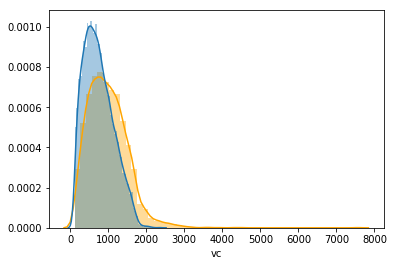

In [0]:
plt.figure(figsize=(6,4))
sns.distplot(train_df[train_df['label']==1]['vc'],color ='orange')
sns.distplot(train_df[train_df['label']==0]['vc'])
plt.show()

In [0]:
cols = [c for c in train_df.columns if 'max' in c]

len(cols)

27

first: 3.9, last: 2000.0


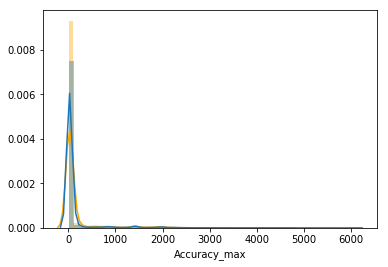

first: 144.0, last: 359.9605276489258


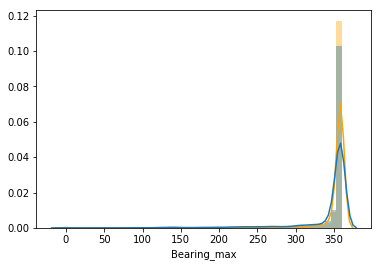

first: 0.6910933222812501, last: 15.045571384599564


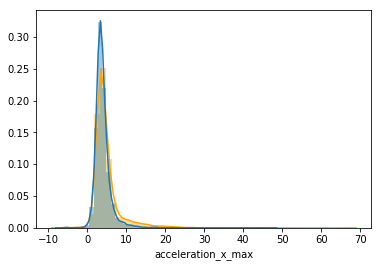

first: -7.815888793945312, last: 20.891290739999988


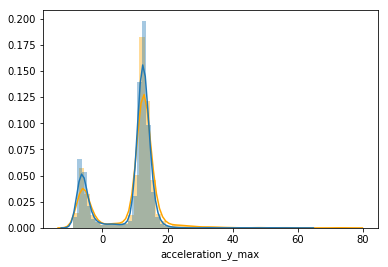

first: -2.8881184387207037, last: 24.20820664999995


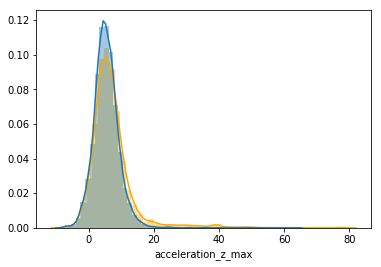

first: 0.067913364, last: 4.537279431529613


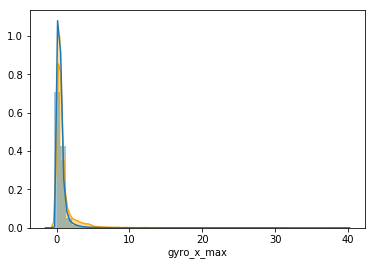

first: 0.11118286151000001, last: 10.203713642211486


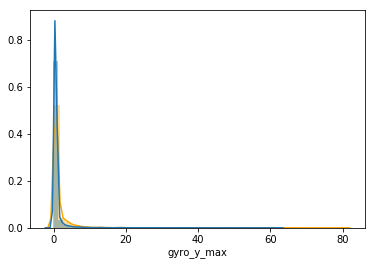

first: 0.05759323218, last: 5.121894909532992


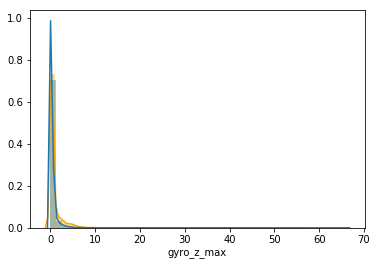

first: 149.0, last: 2251.1899999999987


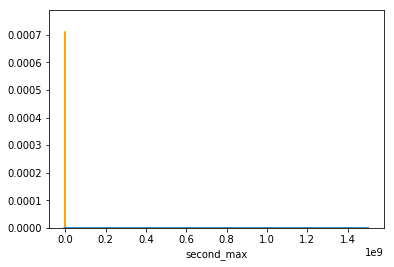

first: 7.240071272850159, last: 31.522261447906477


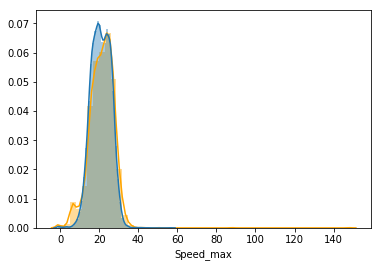

first: 10.900350279126986, last: 34.18204769366129


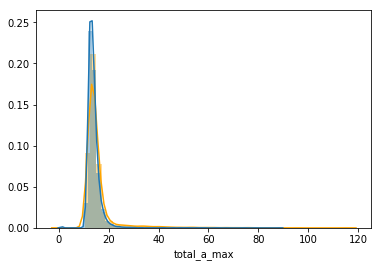

first: 0.23216477059711832, last: 15.877144288545948


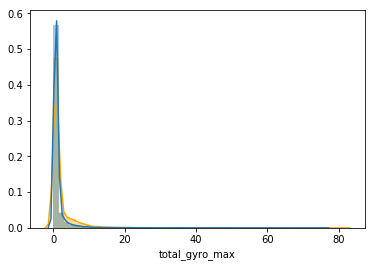

first: -1.836115503766333, last: 3.137180272919637


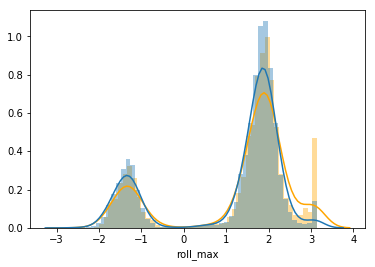

first: 0.048577563593009535, last: 1.3990910549616062


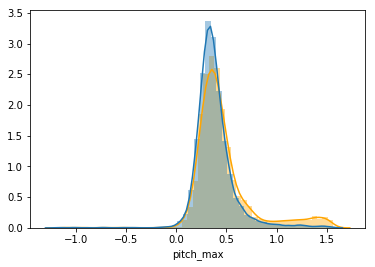

first: 91.59903191575349, last: 462.9101945048294


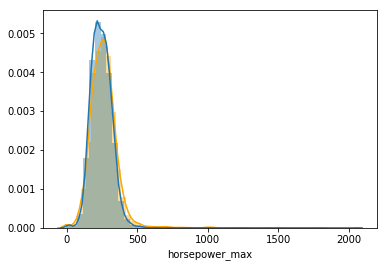

first: 2.0475198121500005, last: 18.72206606776756


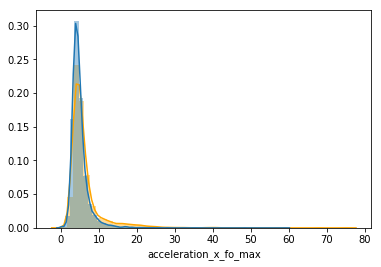

first: 3.513895784933, last: 32.86098830134756


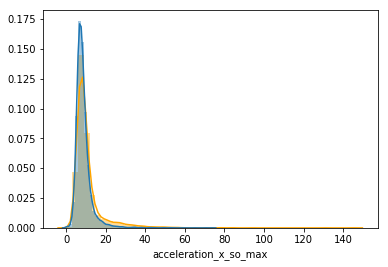

first: 1.5629366130468754, last: 24.386784031162094


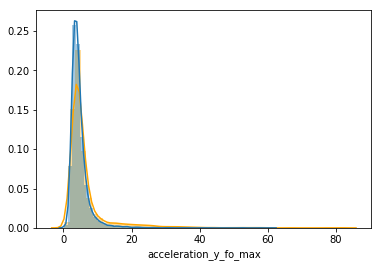

first: 2.6787771399999993, last: 43.566533254999904


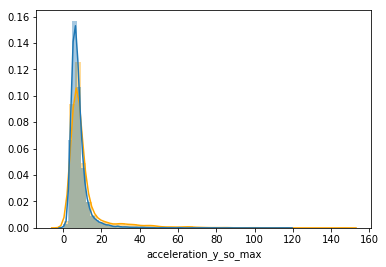

first: 2.362032264142578, last: 25.174746774999814


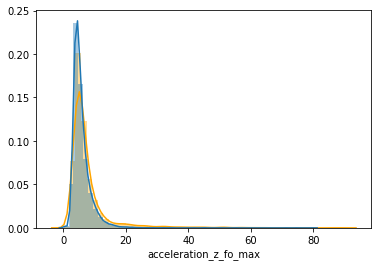

first: 4.006108337685546, last: 43.59693596999971


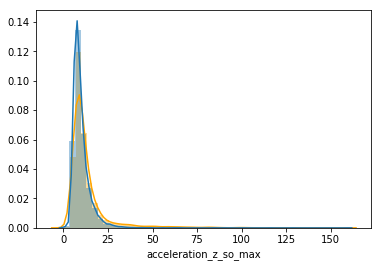

first: 0.09453532730311347, last: 5.506445256993385


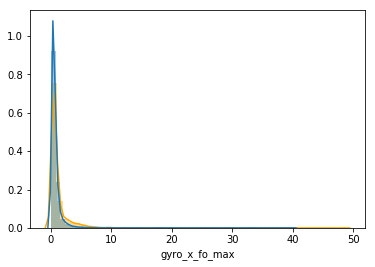

first: 0.15904722388400003, last: 9.585273999046976


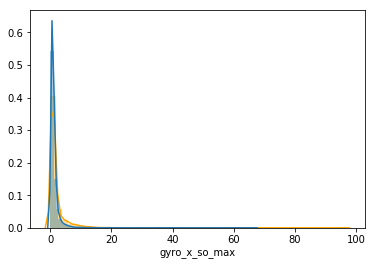

first: 0.17705860465876255, last: 14.004920363499846


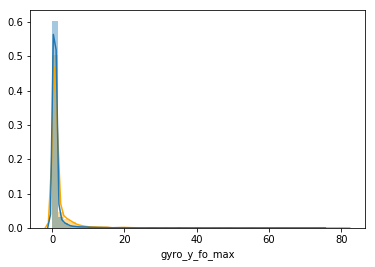

first: 0.28541229754, last: 22.983838554499705


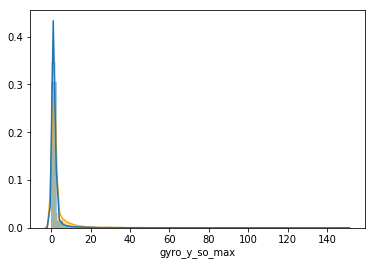

first: 0.080825196115, last: 6.484944022069998


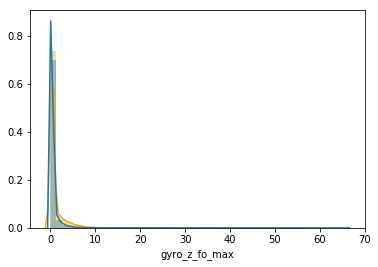

first: 0.137653961891, last: 11.227881731914973


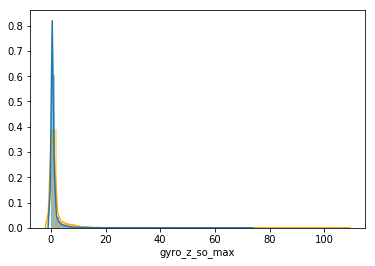

In [0]:
for col in cols:
    sample = train_df[[col, 'label']]

    # set outliers to the 1st and 99th quantile
    # winsorization
    last_quant = sample[col].quantile(.99)
    first_quant = sample[col].quantile(.01)
    
    print('first: {}, last: {}'.format(first_quant, last_quant))

    sample.loc[sample[col] > last_quant, col] = last_quant
    sample.loc[sample[col] < first_quant, col] = first_quant
    
    plt.figure(figsize=(6,4))
    sns.distplot(train_df[train_df['label']==1][col],color ='orange')
    sns.distplot(train_df[train_df['label']==0][col])
    plt.show()

In [0]:
# plt.figure(figsize=(15,30))
# for i, col in enumerate(cols):
#     plt.subplot(9, 3, i+1)
#     sns.distplot(train_df[train_df['label']==1][col],color ='orange')
#     sns.distplot(train_df[train_df['label']==0][col])
#     plt.title(col)